# Use cases scoping
NLP use case scoping: https://www.ibm.com/topics/natural-language-processing
1. Spam detection
2. Machine translation
3. Virtual agents and chatbots
4. Social media sentiment analysis
5. Text summarizationve?

# UCI ML Drug Review dataset

url = https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018?select=drugsComTrain_raw.csv

Problems:
1. Classification: Can you predict the patient's condition based on the review?
2. Regression: Can you predict the rating of the drug based on the review?
3. Sentiment analysis: What elements of a review make it more helpful to others? Which patients tend to have more negative reviews? Can you determine if a review is positive, neutral, or negative?
4. Data visualizations: What kind of drugs are there? What sorts of conditions do these patients have?

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

plt.style.use("ggplot")

# from collections import Counter
import spacy
#import nltk
import nltk

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

import sklearn.metrics as metrics

# Read Data

In [309]:
df_train = pd.read_csv(r"..\Data\drugsComTrain_raw.csv")
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [84]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     161297 non-null  int64 
 1   drugName     161297 non-null  object
 2   condition    160398 non-null  object
 3   review       161297 non-null  object
 4   rating       161297 non-null  int64 
 5   date         161297 non-null  object
 6   usefulCount  161297 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


In [304]:
df_train.describe()

,uniqueID,rating,usefulCount
count,55494.000000,55494.000000,55494.000000
mean,115987.401305,6.725358,23.258064
std,64285.529611,3.245623,39.744089
min,4.000000,1.000000,0.000000
25%,61496.250000,4.000000,4.000000
50%,117568.500000,8.000000,10.000000
75%,168083.500000,10.000000,27.000000
max,232225.000000,10.000000,1291.000000


In [310]:
print(len(df_train["drugName"].unique()))
print(len(df_train["condition"].unique()))

3436
885


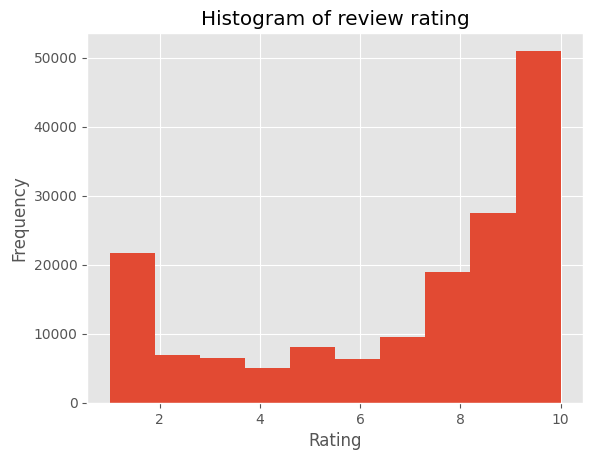

In [315]:
df_train["rating"].plot(kind="hist")
plt.xlabel("Rating")
plt.title("Histogram of review rating")
plt.show()

In [8]:
df_test = pd.read_csv(r"..\Data\drugsComTest_raw.csv")
df_test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   uniqueID     53766 non-null  int64 
 1   drugName     53766 non-null  object
 2   condition    53471 non-null  object
 3   review       53766 non-null  object
 4   rating       53766 non-null  int64 
 5   date         53766 non-null  object
 6   usefulCount  53766 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 2.9+ MB


# Clean data
1. Outliers
2. Null Values

In [3]:
df_train.isna().sum()

uniqueID         0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [4]:
df_train = df_train.replace(np.nan,"NA")

In [5]:
df_train[df_train["condition"].str.contains("users found this comment")] # found non parsed text under condition

,uniqueID,drugName,condition,review,rating,date,usefulCount
105,220696,Loestrin 24 Fe,2</span> users found this comment helpful.,"""I&#039;m 16 and I have been on Loestrin 24 f...",3,3-Nov-10,2
196,67383,Provera,4</span> users found this comment helpful.,"""I&#039;m 24 years old and have always had a p...",1,27-Mar-16,4
243,81588,Yaz,3</span> users found this comment helpful.,"""I took Yaz for a little over 2 years. From a...",3,1-Jun-10,3
264,132965,Loestrin 24 Fe,4</span> users found this comment helpful.,"""Took this pill for 1.) Acne and 2.) Birth Con...",2,24-Jun-14,4
391,91050,Norco,11</span> users found this comment helpful.,"""I have suffered with low back pain - 2 surger...",9,15-Mar-09,11
...,...,...,...,...,...,...,...
160322,173464,Alli,99</span> users found this comment helpful.,"""Great pill... You can definitely see it worki...",9,2-Apr-15,99
160791,150010,Soma,62</span> users found this comment helpful.,"""I am sharing a painful experience actually. T...",5,11-Mar-10,62
160899,209239,Geodon,7</span> users found this comment helpful.,"""I&#039;ve been taking Geodon for about a mont...",7,4-Feb-11,7
160921,96527,Neurontin,92</span> users found this comment helpful.,"""At 300mg 4x daily my pain was almost gone. """,9,8-Jul-13,92


In [6]:
df_train["condition"] = df_train["condition"].apply(lambda x: re.sub("\d+<\/span> users found this comment helpful.","NA",x)) # replacing with NA

In [7]:
df_train[df_train["condition"].str.contains("users found this comment")] # checking replacement

,uniqueID,drugName,condition,review,rating,date,usefulCount


In [8]:
df_train.isna().sum() # checking NaN

uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [9]:
print(df_train.shape)
df_train.drop(df_train[df_train["condition"]=="NA"].index,inplace=True) #drop NA condition
print(df_train.shape)

(161297, 7)
(159498, 7)


In [10]:
df_train["condition"].value_counts().values

array([28788,  9069,  6145,  5904,  5588,  4224,  3673,  3609,  3568,
        3383,  2554,  2463,  2321,  2274,  2096,  1859,  1791,  1780,
        1694,  1663,  1607,  1595,  1463,  1455,  1413,  1316,  1244,
        1239,  1164,  1086,  1079,  1014,   995,   973,   945,   927,
         835,   747,   722,   698,   683,   677,   656,   616,   615,
         611,   598,   594,   591,   579,   565,   561,   558,   550,
         524,   519,   508,   506,   502,   501,   473,   449,   439,
         396,   396,   395,   389,   388,   386,   372,   367,   358,
         356,   350,   350,   332,   327,   324,   314,   313,   309,
         303,   298,   290,   276,   273,   272,   272,   264,   260,
         255,   253,   252,   250,   238,   228,   225,   225,   217,
         209,   203,   196,   192,   187,   183,   182,   179,   178,
         176,   175,   173,   171,   168,   168,   166,   166,   166,
         165,   162,   162,   160,   159,   152,   152,   151,   151,
         147,   146,

In [11]:
df_train["condition"].value_counts().head(5)

condition
Birth Control    28788
Depression        9069
Pain              6145
Anxiety           5904
Acne              5588
Name: count, dtype: int64

In [12]:
df_train["condition"].value_counts().head(5).sum()

55494

In [13]:
df_drop = df_train[df_train["condition"]!="Birth Control"]
df_drop = df_drop[df_drop["condition"]!="Depression"]
df_drop = df_drop[df_drop["condition"]!="Pain"]
df_drop = df_drop[df_drop["condition"]!="Anxiety"]
df_drop = df_drop[df_drop["condition"]!="Acne"]
df_train.drop(df_drop.index,inplace=True)
df_train.shape

(55494, 7)

In [ ]:
# 884 unique conditions

# EDA

In [14]:
df_train.reset_index(inplace=True)
df_train.drop(columns=["index"],inplace=True)

In [18]:
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
1,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
2,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1
3,75612,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10,9-Mar-17,54
4,98494,Nexplanon,Birth Control,"""Started Nexplanon 2 months ago because I have...",3,7-Aug-14,10


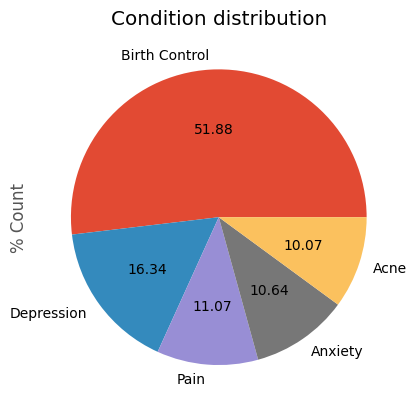

In [168]:
df_train["condition"].value_counts().plot.pie(autopct="%.2f")
plt.ylabel("% Count")
plt.title("Condition distribution")
plt.show()

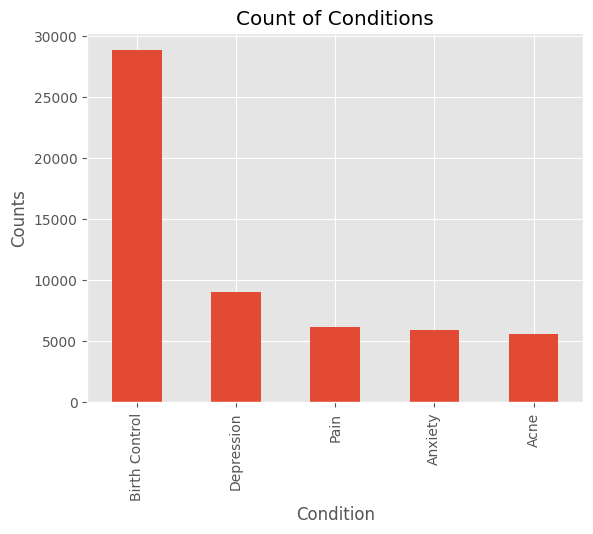

In [199]:
df_train["condition"].value_counts().plot(kind="bar")
plt.ylabel("Counts")
plt.xlabel("Condition")
plt.title("Count of Conditions")
plt.show()

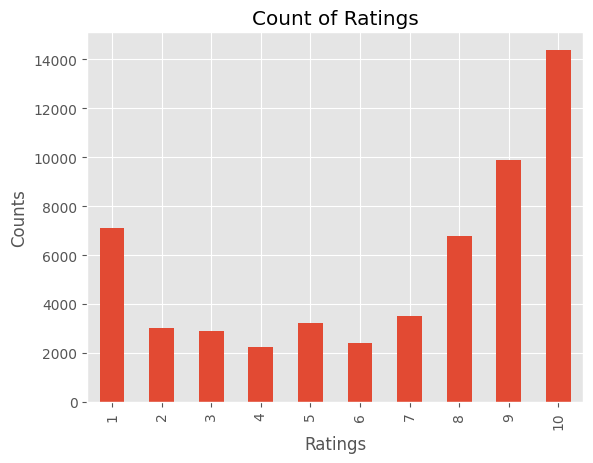

In [200]:
df_train["rating"].value_counts().sort_index().plot(kind="bar")
plt.ylabel("Counts")
plt.xlabel("Ratings")
plt.title("Count of Ratings")
plt.show()

In [230]:
df_train[df_train["condition"]=="Acne"]["rating"].mean()

7.374194702934861

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


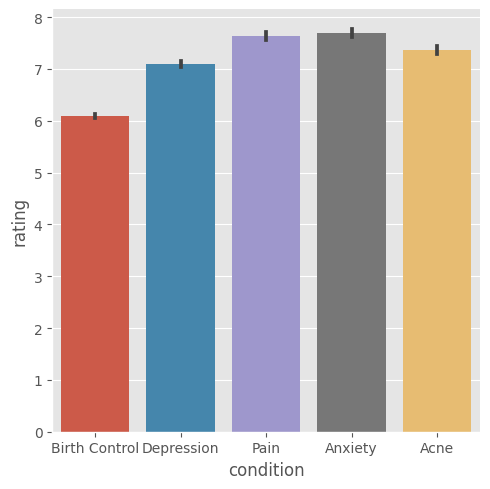

In [222]:
sns.catplot(data=df_train, kind="bar", x="condition", y="rating")
plt.show()

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 2000x1000 with 0 Axes>

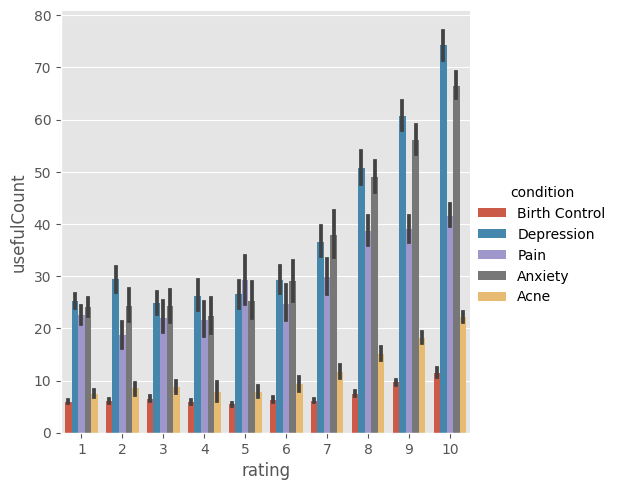

In [218]:
plt.figure(figsize=(20,10))
sns.catplot(data=df_train, kind="bar", x="rating", y="usefulCount", hue="condition")
plt.show()

# Modelling

## Split data

In [20]:
## split the dataset
X = df_train["review"]
y = df_train["condition"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [21]:
## helper function for classifier

def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)

    return metrics.accuracy_score(predictions, y_test), metrics.f1_score(predictions, y_test,average="macro")

In [64]:
## helper function for regression

def train_model_reg(regressor, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    regressor.fit(feature_vector_train, label)

    # predict the labels on validation dataset
    predictions = regressor.predict(feature_vector_valid)

    return metrics.r2_score(predictions, y_test), metrics.mean_squared_error(predictions, y_test)

In [22]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Count Vectors',
                                  'WordLevel TF-IDF',
                                  'N-Gram Vectors',
                                  'CharLevel Vectors'])

## Initialize CountVectorizer, TfidfVectorizer

In [23]:
# create a count vectorizer object
count_vect = CountVectorizer(token_pattern = r'\w{1,}')

# Learn a vocabulary dictionary of all tokens in the raw documents
count_vect.fit(X)

# Transform documents to document-term matrix.
X_train_count = count_vect.transform(X_train)
X_test_count = count_vect.transform(X_test)

In [24]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer = 'word',
                             token_pattern = r'\w{1,}',
                             max_features = 5000)
print(tfidf_vect)

tfidf_vect.fit(X)
X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf  = tfidf_vect.transform(X_test)

TfidfVectorizer(max_features=5000, token_pattern='\\w{1,}')


In [25]:
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer = 'word',
                                   token_pattern = r'\w{1,}',
                                   ngram_range = (2, 3),
                                   max_features = 5000)
print(tfidf_vect_ngram)

tfidf_vect_ngram.fit(X)
X_train_tfidf_ngram = tfidf_vect_ngram.transform(X_train)
X_test_tfidf_ngram  = tfidf_vect_ngram.transform(X_test)

TfidfVectorizer(max_features=5000, ngram_range=(2, 3), token_pattern='\\w{1,}')


In [26]:
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer = 'char',
                                         token_pattern = r'\w{1,}',
                                         ngram_range = (2, 3),
                                         max_features = 5000)
print(tfidf_vect_ngram_chars)

tfidf_vect_ngram_chars.fit(X)
X_train_tfidf_ngram_chars = tfidf_vect_ngram_chars.transform(X_train)
X_test_tfidf_ngram_chars  = tfidf_vect_ngram_chars.transform(X_test)

TfidfVectorizer(analyzer='char', max_features=5000, ngram_range=(2, 3),
                token_pattern='\\w{1,}')


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:555: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(


## Classification: Can you predict the patient's condition based on the review?

### LogisticRegression

In [35]:
# Linear Classifier on Count Vectors
accuracy1,f1_1 = train_model(LogisticRegression(solver="newton-cg",multi_class="multinomial",max_iter=300), X_train_count, y_train, X_test_count)
print('LR, Count Vectors accuracy: %.4f\n' % accuracy1)
print('LR, Count Vectors macro_f1: %.4f\n' % f1_1)

LR, Count Vectors accuracy: 0.9398

LR, Count Vectors macro_f1: 0.9126



In [36]:
# Linear Classifier on Word Level TF IDF Vectors
accuracy2,f1_2 = train_model(LogisticRegression(solver="newton-cg",multi_class="multinomial",max_iter=300), X_train_tfidf, y_train, X_test_tfidf)
print('LR, WordLevel TF-IDF accuracy: %.4f\n' % accuracy2)
print('LR, WordLevel TF-IDF macro_f1: %.4f\n' % f1_2)

LR, WordLevel TF-IDF accuracy: 0.9276

LR, WordLevel TF-IDF macro_f1: 0.8970



In [37]:
# Linear Classifier on Ngram Level TF IDF Vectors
accuracy3,f1_3 = train_model(LogisticRegression(solver="newton-cg",multi_class="multinomial",max_iter=300), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('LR, N-Gram Vectors accuracy: %.4f\n' % accuracy3)
print('LR, N-Gram Vectors macro_f1: %.4f\n' % f1_3)

LR, N-Gram Vectors accuracy: 0.8852

LR, N-Gram Vectors macro_f1: 0.8361



In [38]:
# Linear Classifier on Character Level TF IDF Vectors
accuracy4,f1_4 = train_model(LogisticRegression(solver="newton-cg",multi_class="multinomial",max_iter=300), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('LR, CharLevel Vectors accuracy: %.4f\n' % accuracy4)
print('LR, CharLevel Vectors macro_f1: %.4f\n' % f1_4)

LR, CharLevel Vectors accuracy: 0.9212

LR, CharLevel Vectors macro_f1: 0.8898



In [39]:
results.loc['Logistic Regression'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

In [278]:
count_vect = CountVectorizer(token_pattern = r'\w{1,}')
X_test_count = count_vect.fit_transform(df_train["review"])

In [279]:
test_model = LogisticRegression(solver="newton-cg",multi_class="multinomial",max_iter=300)
test_model.fit(X_train_count,y_train)
test_model.predict(X_test_count)

array(['Birth Control', 'Birth Control', 'Birth Control', ...,
       'Depression', 'Anxiety', 'Birth Control'], dtype=object)

In [298]:
df_train.sample(1,random_state=1)                

,uniqueID,drugName,condition,review,rating,date,usefulCount
5494,190025,Stadol,Pain,"""I have been using Stadol Nasal Spray for at l...",9,4-Jan-11,30


In [306]:
print("Sample:\n",df_train.sample(1,random_state=1)["condition"])
print("\nPred_Condition: ",test_model.predict(X_test_count[df_train.sample(1,random_state=1).index])[0])

Sample:
 5494    Pain
Name: condition, dtype: object

Pred_Condition:  Pain


In [309]:
print("Sample:\n",df_train.sample(1,random_state=2)["condition"])
print("\nPred_Condition: ",test_model.predict(X_test_count[df_train.sample(1,random_state=2).index])[0])

Sample:
 34977    Depression
Name: condition, dtype: object

Pred_Condition:  Depression


In [310]:
print("Sample:\n",df_train.sample(1,random_state=3)["condition"])
print("\nPred_Condition: ",test_model.predict(X_test_count[df_train.sample(1,random_state=3).index])[0])

Sample:
 41657    Anxiety
Name: condition, dtype: object

Pred_Condition:  Anxiety


In [311]:
print("Sample:\n",df_train.sample(1,random_state=4)["condition"])
print("\nPred_Condition: ",test_model.predict(X_test_count[df_train.sample(1,random_state=4).index])[0])

Sample:
 18554    Birth Control
Name: condition, dtype: object

Pred_Condition:  Birth Control


### Naive Bayes

#### GaussianNB

In [27]:
# Naive Bayes classifier on Count Vectors
accuracy1,f1_1 = train_model(GaussianNB(), X_train_count.toarray(), y_train, X_test_count.toarray())
print('LR, Count Vectors accuracy: %.4f\n' % accuracy1)
print('LR, Count Vectors macro_f1: %.4f\n' % f1_1)

LR, Count Vectors accuracy: 0.6241

LR, Count Vectors macro_f1: 0.6026



#### BernoulliNB

In [30]:
# Naive Bayes classifier on Count Vectors
accuracy1_ber,f1_ber = train_model(BernoulliNB(), X_train_count.toarray(), y_train, X_test_count.toarray())
print('LR, Count Vectors accuracy: %.4f\n' % accuracy1_ber)
print('LR, Count Vectors macro_f1: %.4f\n' % f1_ber)

LR, Count Vectors accuracy: 0.8821

LR, Count Vectors macro_f1: 0.8305



In [31]:
# Naive Bayes classifier on Count Vectors
accuracy2_ber,f2_ber = train_model(BernoulliNB(), X_train_tfidf.toarray(), y_train, X_test_tfidf.toarray())
print('BerNB, WordLevel TF-IDF accuracy: %.4f\n' % accuracy2_ber)
print('BerNB, WordLevel TF-IDF macro_f1: %.4f\n' % f2_ber)

BerNB, WordLevel TF-IDF accuracy: 0.8717

BerNB, WordLevel TF-IDF macro_f1: 0.8202



In [32]:
# Naive Bayes classifier on Count Vectors
accuracy3_ber,f3_ber = train_model(BernoulliNB(), X_train_tfidf_ngram.toarray(), y_train, X_test_tfidf_ngram.toarray())
print('BerNB, N-Gram Vectors accuracy: %.4f\n' % accuracy3_ber)
print('BerNB, N-Gram Vectors macro_f1: %.4f\n' % f3_ber)

BerNB, N-Gram Vectors accuracy: 0.7960

BerNB, N-Gram Vectors macro_f1: 0.7259



In [33]:
# Naive Bayes classifier on Count Vectors
accuracy4_ber,f4_ber = train_model(BernoulliNB(), X_train_tfidf_ngram_chars.toarray(), y_train, X_test_tfidf_ngram_chars.toarray())
print('BerNB, CharLevel Vectors accuracy: %.4f\n' % accuracy4_ber)
print('BerNB, CharLevel Vectors macro_f1: %.4f\n' % f4_ber)

BerNB, CharLevel Vectors accuracy: 0.7856

BerNB, CharLevel Vectors macro_f1: 0.7291



In [34]:
results.loc['BernoulliNB'] = {
    'Count Vectors': accuracy1_ber,
    'WordLevel TF-IDF': accuracy2_ber,
    'N-Gram Vectors': accuracy3_ber,
    'CharLevel Vectors': accuracy4_ber}

### SVM

In [42]:
# Support Vector Machine Classifier on Count Vectors
accuracy1,f1_1 = train_model(SVC(), X_train_count, y_train, X_test_count)
print('SVC, Count Vectors accuracy: %.4f\n' % accuracy1)
print('SVC, Count Vectors macro_f1: %.4f\n' % f1_1)

SVC, Count Vectors accuracy: 0.9164

SVC, Count Vectors macro_f1: 0.8818



In [43]:
# Support Vector Machine Classifier on Count Vectors
accuracy2,f1_2 = train_model(SVC(), X_train_tfidf, y_train, X_test_tfidf)
print('SVC, TFIDF Vectors accuracy: %.4f\n' % accuracy2)
print('SVC, TFIDF Vectors macro_f1: %.4f\n' % f1_2)

SVC, TFIDF Vectors accuracy: 0.9505

SVC, TFIDF Vectors macro_f1: 0.9293



In [44]:
# Support Vector Machine Classifier on Count Vectors
accuracy3,f1_3 = train_model(SVC(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('SVC, TFIDF Vectors accuracy: %.4f\n' % accuracy3)
print('SVC, TFIDF Vectors macro_f1: %.4f\n' % f1_3)

SVC, TFIDF Vectors accuracy: 0.9206

SVC, TFIDF Vectors macro_f1: 0.8858



In [45]:
# Support Vector Machine Classifier on Count Vectors
accuracy4,f1_4 = train_model(SVC(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('SVC, TFIDF Vectors accuracy: %.4f\n' % accuracy4)
print('SVC, TFIDF Vectors macro_f1: %.4f\n' % f1_4)

SVC, TFIDF Vectors accuracy: 0.9426

SVC, TFIDF Vectors macro_f1: 0.9172



In [46]:
results.loc['SVC'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

### Bagging

In [48]:
# Bagging classifier on Count Vectors
accuracy1,f1_1 = train_model(RandomForestClassifier(), X_train_count, y_train, X_test_count)
print('RandF, Count Vectors accuracy: %.4f\n' % accuracy1)
print('RandF, Count Vectors macro_f1: %.4f\n' % f1_1)

RandF, Count Vectors accuracy: 0.9335

RandF, Count Vectors macro_f1: 0.9105



In [50]:
# Bagging classifier on Count Vectors
accuracy2,f1_2 = train_model(RandomForestClassifier(), X_train_tfidf, y_train, X_test_tfidf)
print('RandF, Count Vectors accuracy: %.4f\n' % accuracy2)
print('RandF, Count Vectors macro_f1: %.4f\n' % f1_2)

RandF, Count Vectors accuracy: 0.9391

RandF, Count Vectors macro_f1: 0.9158



In [51]:
# Bagging classifier on Count Vectors
accuracy3,f1_3 = train_model(RandomForestClassifier(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('RandF, Count Vectors accuracy: %.4f\n' % accuracy3)
print('RandF, Count Vectors macro_f1: %.4f\n' % f1_3)

RandF, Count Vectors accuracy: 0.9059

RandF, Count Vectors macro_f1: 0.8737



In [52]:
# Bagging classifier on Count Vectors
accuracy4,f1_4 = train_model(RandomForestClassifier(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('RandF, Count Vectors accuracy: %.4f\n' % accuracy4)
print('RandF, Count Vectors macro_f1: %.4f\n' % f1_4)

RandF, Count Vectors accuracy: 0.9340

RandF, Count Vectors macro_f1: 0.9115



In [53]:
results.loc['RandomForestClassifier'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

## Regression: Can you predict the rating of the drug based on the review?

In [62]:
# Keep the results in a dataframe
results_reg = pd.DataFrame(columns = ['Count Vectors',
                                  'WordLevel TF-IDF',
                                  'N-Gram Vectors',
                                  'CharLevel Vectors'])

### Linear Regression

In [55]:
## split the dataset
X = df_train["review"]
y = df_train["rating"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [56]:
# create a count vectorizer object
count_vect = CountVectorizer(token_pattern = r'\w{1,}')

# Learn a vocabulary dictionary of all tokens in the raw documents
count_vect.fit(X)

# Transform documents to document-term matrix.
X_train_count = count_vect.transform(X_train)
X_test_count = count_vect.transform(X_test)

In [57]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer = 'word',
                             token_pattern = r'\w{1,}',
                             max_features = 5000)
print(tfidf_vect)

tfidf_vect.fit(X)
X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf  = tfidf_vect.transform(X_test)

TfidfVectorizer(max_features=5000, token_pattern='\\w{1,}')


In [58]:
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer = 'word',
                                   token_pattern = r'\w{1,}',
                                   ngram_range = (2, 3),
                                   max_features = 5000)
print(tfidf_vect_ngram)

tfidf_vect_ngram.fit(X)
X_train_tfidf_ngram = tfidf_vect_ngram.transform(X_train)
X_test_tfidf_ngram  = tfidf_vect_ngram.transform(X_test)

TfidfVectorizer(max_features=5000, ngram_range=(2, 3), token_pattern='\\w{1,}')


In [59]:
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer = 'char',
                                         token_pattern = r'\w{1,}',
                                         ngram_range = (2, 3),
                                         max_features = 5000)
print(tfidf_vect_ngram_chars)

tfidf_vect_ngram_chars.fit(X)
X_train_tfidf_ngram_chars = tfidf_vect_ngram_chars.transform(X_train)
X_test_tfidf_ngram_chars  = tfidf_vect_ngram_chars.transform(X_test)

TfidfVectorizer(analyzer='char', max_features=5000, ngram_range=(2, 3),
                token_pattern='\\w{1,}')


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:555: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [65]:
# Linear regression on Count Vectors
r2_1,mean2error_1 = train_model_reg(LinearRegression(), X_train_count, y_train, X_test_count)
print('LR, Count Vectors r2: %.4f\n' % r2_1)
print('LR, Count Vectors mean2error: %.4f\n' % mean2error_1)

LR, Count Vectors r2: 0.2381

LR, Count Vectors mean2error: 11.9178



In [66]:
# Linear regression on Count Vectors
r2_2,mean2error_2 = train_model_reg(LinearRegression(), X_train_tfidf, y_train, X_test_tfidf)
print('LR, Count Vectors r2: %.4f\n' % r2_2)
print('LR, Count Vectors mean2error: %.4f\n' % mean2error_2)

LR, Count Vectors r2: 0.2213

LR, Count Vectors mean2error: 5.0865



In [67]:
# Linear regression on Count Vectors
r2_3,mean2error_3 = train_model_reg(LinearRegression(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('LR, Count Vectors r2: %.4f\n' % r2_3)
print('LR, Count Vectors mean2error: %.4f\n' % mean2error_3)

LR, Count Vectors r2: 0.1484

LR, Count Vectors mean2error: 5.2783



In [68]:
# Linear regression on Count Vectors
r2_4,mean2error_4 = train_model_reg(LinearRegression(), X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('LR, Count Vectors r2: %.4f\n' % r2_4)
print('LR, Count Vectors mean2error: %.4f\n' % mean2error_4)

LR, Count Vectors r2: 0.1868

LR, Count Vectors mean2error: 5.2333



In [70]:
test_model = LinearRegression()
test_model.fit(X_train_count,y_train)
pred = test_model.predict(X_train_count)
print(metrics.r2_score(pred, y_train))

0.7473370211783532


In [71]:
pred = test_model.predict(X_test_count)
print(metrics.r2_score(pred, y_test))

0.23812370404521133


In [75]:
results_reg.loc['LinearRegression'] = {
    'Count Vectors': r2_1,
    'WordLevel TF-IDF': r2_2,
    'N-Gram Vectors': r2_3,
    'CharLevel Vectors': r2_4}

### RidgeCV

In [78]:
ridge_alphas = np.logspace(-6, 6, 10)
ridge_alphas

array([1.00000000e-06, 2.15443469e-05, 4.64158883e-04, 1.00000000e-02,
       2.15443469e-01, 4.64158883e+00, 1.00000000e+02, 2.15443469e+03,
       4.64158883e+04, 1.00000000e+06])

In [79]:
# Linear regression on Count Vectors
r2_1,mean2error_1 = train_model_reg(RidgeCV(alphas=ridge_alphas, cv=5), X_train_count, y_train, X_test_count)
print('LR, Count Vectors r2: %.4f\n' % r2_1)
print('LR, Count Vectors mean2error: %.4f\n' % mean2error_1)

LR, Count Vectors r2: -0.0867

LR, Count Vectors mean2error: 5.3074



### LassoCV

In [ ]:
# Linear regression on Count Vectors
r2_1,mean2error_1 = train_model_reg(LassoCV(alphas=ridge_alphas, cv=5), X_train_count, y_train, X_test_count)
print('LR, Count Vectors r2: %.4f\n' % r2_1)
print('LR, Count Vectors mean2error: %.4f\n' % mean2error_1)

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 458.51402610678633, tolerance: 37.48054243439579
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34656.56813485936, tolerance: 37.48054243439579
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4318.3037663763025, tolerance: 37.36175443180542
  model = cd_fast.sparse_enet_coordinate_descent(

### Ridge Lasso

In [ ]:
# Linear regression on Count Vectors
r2_1,mean2error_1 = train_model_reg(Ridge(), X_train_count, y_train, X_test_count)
print('LR, Count Vectors r2: %.4f\n' % r2_1)
print('LR, Count Vectors mean2error: %.4f\n' % mean2error_1)

In [ ]:
# Linear regression on Count Vectors
r2_1,mean2error_1 = train_model_reg(Lasso(), X_train_count, y_train, X_test_count)
print('LR, Count Vectors r2: %.4f\n' % r2_1)
print('LR, Count Vectors mean2error: %.4f\n' % mean2error_1)

## Sentiment analysis: What elements of a review make it more helpful to others? Which patients tend to have more negative reviews? Can you determine if a review is positive, neutral, or negative?

### VADER (Valence Aware Dictionary for Sentiment Reasoning)

In [26]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [27]:
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
1,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
2,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1
3,75612,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10,9-Mar-17,54
4,98494,Nexplanon,Birth Control,"""Started Nexplanon 2 months ago because I have...",3,7-Aug-14,10


In [28]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [29]:
sia.polarity_scores("The food is great!")

{'neg': 0.0, 'neu': 0.406, 'pos': 0.594, 'compound': 0.6588}

In [30]:
sia.polarity_scores("The food is not great!")

{'neg': 0.473, 'neu': 0.527, 'pos': 0.0, 'compound': -0.5553}

In [31]:
vader_res = {}
for _,row in df_train.iterrows():
    p_score = sia.polarity_scores(row["review"])
    vader_res[row["uniqueID"]] = p_score
vader_res

{92703: {'neg': 0.041, 'neu': 0.876, 'pos': 0.084, 'compound': 0.7962},
 138000: {'neg': 0.027, 'neu': 0.879, 'pos': 0.093, 'compound': 0.7184},
 48928: {'neg': 0.202, 'neu': 0.642, 'pos': 0.156, 'compound': -0.901},
 75612: {'neg': 0.221, 'neu': 0.567, 'pos': 0.212, 'compound': 0.0147},
 98494: {'neg': 0.113, 'neu': 0.786, 'pos': 0.101, 'compound': -0.4309},
 227020: {'neg': 0.067, 'neu': 0.848, 'pos': 0.085, 'compound': 0.5325},
 96233: {'neg': 0.027, 'neu': 0.896, 'pos': 0.077, 'compound': 0.5423},
 204999: {'neg': 0.146, 'neu': 0.854, 'pos': 0.0, 'compound': -0.6876},
 93678: {'neg': 0.091, 'neu': 0.909, 'pos': 0.0, 'compound': -0.5106},
 121333: {'neg': 0.134, 'neu': 0.744, 'pos': 0.122, 'compound': -0.5862},
 69629: {'neg': 0.148, 'neu': 0.738, 'pos': 0.114, 'compound': -0.2944},
 106703: {'neg': 0.139, 'neu': 0.715, 'pos': 0.146, 'compound': 0.1664},
 131704: {'neg': 0.313, 'neu': 0.579, 'pos': 0.108, 'compound': -0.9621},
 192806: {'neg': 0.13, 'neu': 0.761, 'pos': 0.109, 'comp

In [32]:
df_train["review"][0]

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

In [33]:
sia.polarity_scores(df_train["review"][0])

{'neg': 0.041, 'neu': 0.876, 'pos': 0.084, 'compound': 0.7962}

In [34]:
vader_df = pd.DataFrame(vader_res).T
vader_df = vader_df.reset_index().rename(columns={"index":"uniqueID"})
vader_df = vader_df.merge(df_train, how="left")
vader_df.head()

,uniqueID,neg,neu,pos,compound,drugName,condition,review,rating,date,usefulCount
0,92703,0.041,0.876,0.084,0.7962,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
1,138000,0.027,0.879,0.093,0.7184,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
2,48928,0.202,0.642,0.156,-0.9010,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1
3,75612,0.221,0.567,0.212,0.0147,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10,9-Mar-17,54
4,98494,0.113,0.786,0.101,-0.4309,Nexplanon,Birth Control,"""Started Nexplanon 2 months ago because I have...",3,7-Aug-14,10


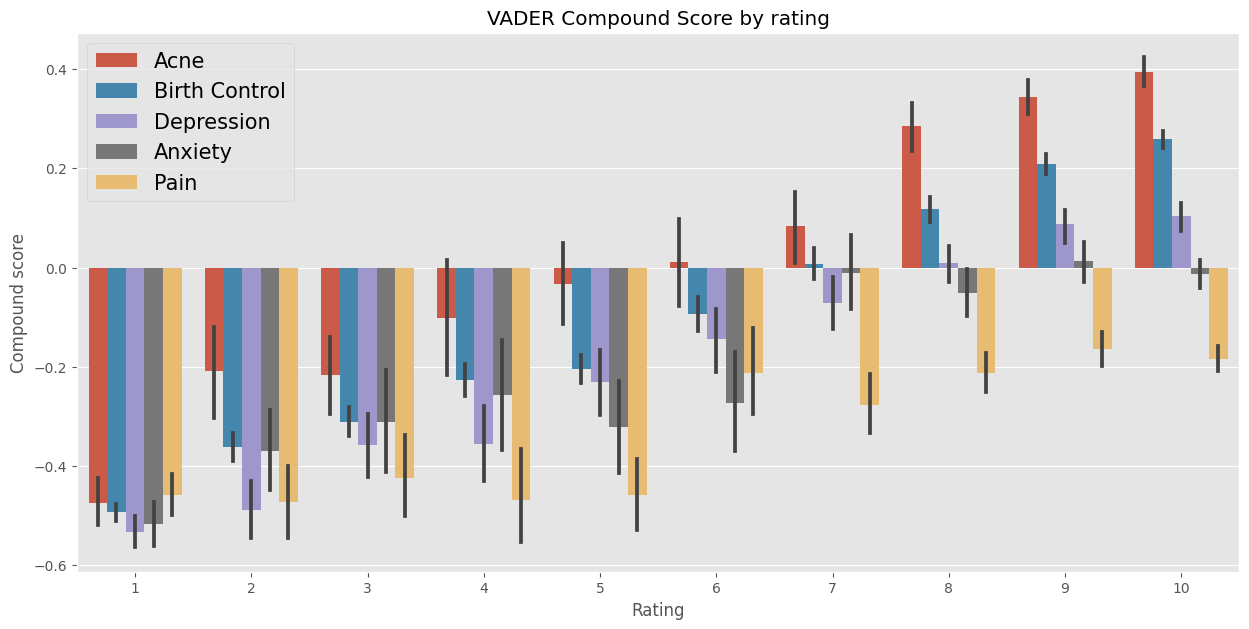

In [129]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(data=vader_df, x="rating", y="compound",hue="condition",hue_order=["Acne","Birth Control","Depression","Anxiety","Pain"],ax=ax)
ax.set_title("VADER Compound Score by rating")
ax.set_xlabel("Rating")
ax.set_ylabel("Compound score")
ax.legend(fontsize="15")
plt.show()

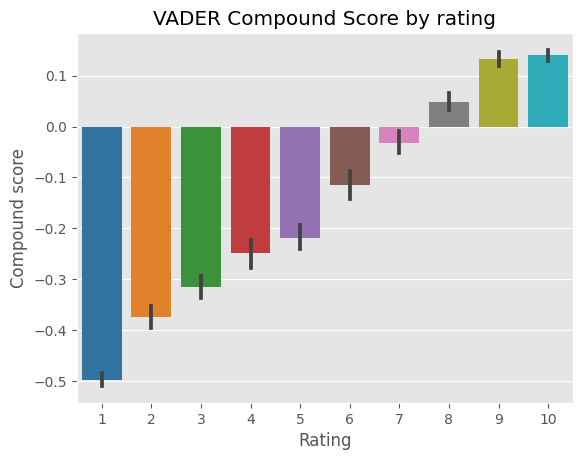

In [157]:
fig, ax = plt.subplots()
sns.barplot(data=vader_df, x="rating", y="compound",ax=ax,palette="tab10")
ax.set_title("VADER Compound Score by rating")
ax.set_xlabel("Rating")
ax.set_ylabel("Compound score")
plt.show()

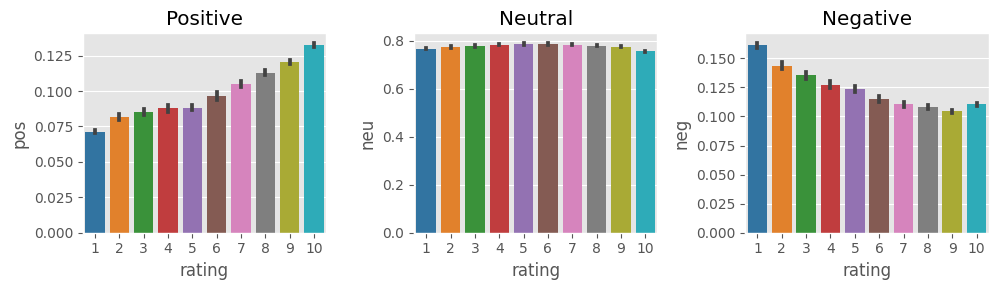

In [159]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
sns.barplot(data=vader_df, x="rating", y="pos", ax=axs[0],palette="tab10")
sns.barplot(data=vader_df, x="rating", y="neu", ax=axs[1],palette="tab10")
sns.barplot(data=vader_df, x="rating", y="neg", ax=axs[2],palette="tab10")
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.tight_layout()
plt.show()

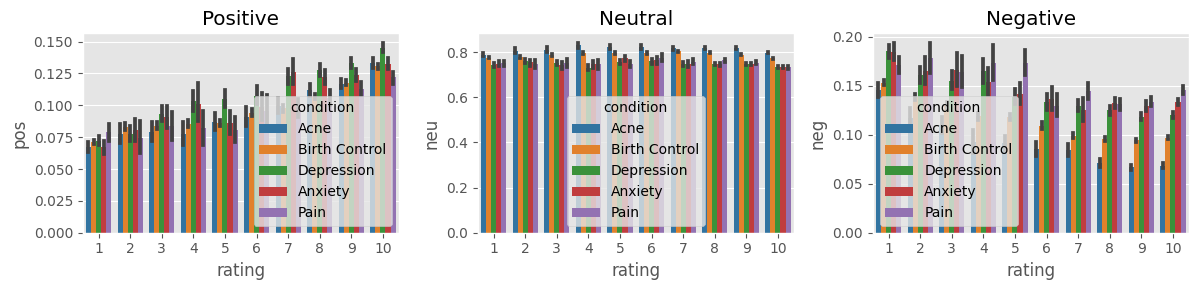

In [150]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vader_df, x="rating", y="pos", ax=axs[0],palette="tab10",hue="condition",hue_order=["Acne","Birth Control","Depression","Anxiety","Pain"])
sns.barplot(data=vader_df, x="rating", y="neu", ax=axs[1],palette="tab10",hue="condition",hue_order=["Acne","Birth Control","Depression","Anxiety","Pain"])
sns.barplot(data=vader_df, x="rating", y="neg", ax=axs[2],palette="tab10",hue="condition",hue_order=["Acne","Birth Control","Depression","Anxiety","Pain"])
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.tight_layout()
plt.show()

In [50]:
vader_neg_reviews_df = vader_df[vader_df["compound"]<0].groupby("condition").agg({"condition":"count"})
vader_neg_reviews_df.rename(columns={"condition":"neg_count"},inplace=True)
vader_neg_reviews_df.reset_index(inplace=True)
vader_neg_reviews_df

,condition,neg_count
0,Acne,2138
1,Anxiety,3199
2,Birth Control,15243
3,Depression,4806
4,Pain,3934


In [51]:
condition_tcount_df = df_train.groupby("condition").agg({"condition":"count"})
condition_tcount_df.rename(columns={"condition":"total_count"},inplace=True)
condition_tcount_df.reset_index(inplace=True)
condition_tcount_df

,condition,total_count
0,Acne,5588
1,Anxiety,5904
2,Birth Control,28788
3,Depression,9069
4,Pain,6145


In [54]:
vader_neg_reviews_df = vader_neg_reviews_df.merge(condition_tcount_df,how="left")
vader_neg_reviews_df

,condition,neg_count,total_count
0,Acne,2138,5588
1,Anxiety,3199,5904
2,Birth Control,15243,28788
3,Depression,4806,9069
4,Pain,3934,6145


In [57]:
(np.array(vader_neg_reviews_df["neg_count"])/np.array(vader_neg_reviews_df["total_count"]))*100

array([38.26055834, 54.18360434, 52.94914548, 52.99371485, 64.01952807])

In [72]:
vader_neg_reviews_df["neg_ratio"] = (np.array(vader_neg_reviews_df["neg_count"])/np.array(vader_neg_reviews_df["total_count"]))*100
vader_neg_reviews_df["pos_ratio"] = 100-vader_neg_reviews_df["neg_ratio"]
vader_neg_reviews_df

,condition,neg_count,total_count,neg_ratio,pos_ratio
0,Acne,2138,5588,38.260558,61.739442
1,Anxiety,3199,5904,54.183604,45.816396
2,Birth Control,15243,28788,52.949145,47.050855
3,Depression,4806,9069,52.993715,47.006285
4,Pain,3934,6145,64.019528,35.980472


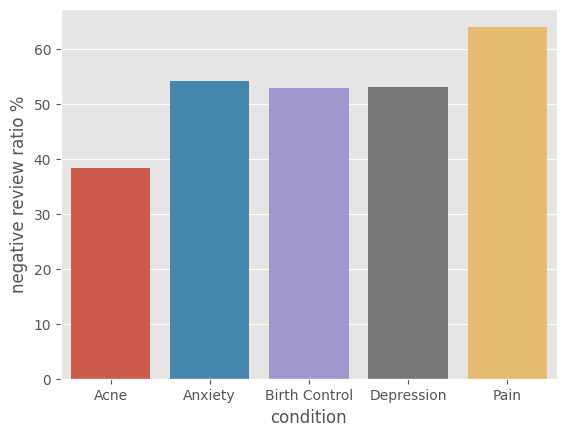

In [61]:
sns.barplot(data=vader_neg_reviews_df,x="condition",y="neg_ratio")
plt.ylabel("negative review ratio %")
plt.show()

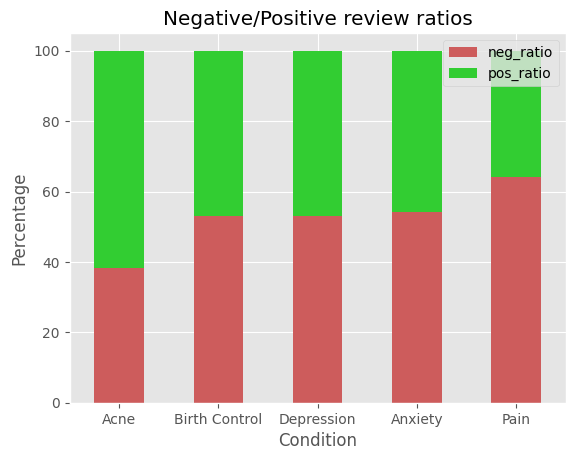

In [141]:
vader_neg_reviews_df.sort_values("neg_ratio").drop(columns=["neg_count","total_count"]).plot(x="condition",kind='bar', stacked=True, color=['indianred', 'limegreen'])
plt.xticks(rotation=0)
plt.xlabel("Condition")
plt.ylabel("Percentage")
plt.title("Negative/Positive review ratios")
plt.show()

### VADER vs roBERTa

In [326]:
print(vader_df[(vader_df["rating"]==7) & (vader_df["condition"]=="Pain")].sample(1)["review"].values[0])
print(sia.polarity_scores(vader_df[(vader_df["rating"]==7) & (vader_df["condition"]=="Pain")].sample(1)["review"].values[0]))
print(polarity_scores_roberta(vader_df[(vader_df["rating"]==7) & (vader_df["condition"]=="Pain")].sample(1)["review"].values[0]))

"I&#039;ve tried numerous meds for back pain and neurogenic pain from MS, Opana works good, although the new formula made me very sick, thank God generic are not the plastic tablets.  3X20 per day and 1-3 Norco for BT.  I use Fentanyl 25mcg on weekend instead of OP to give my digestive tract a break."
{'neg': 0.196, 'neu': 0.743, 'pos': 0.06, 'compound': -0.5932}
{'roberta_neg': 0.10945311, 'roberta_neu': 0.3953968, 'roberta_pos': 0.49515003}


In [328]:
print(vader_df[(vader_df["rating"]==8) & (vader_df["condition"]=="Pain")].sample(1)["review"].values[0])
print(sia.polarity_scores(vader_df[(vader_df["rating"]==8) & (vader_df["condition"]=="Pain")].sample(1)["review"].values[0]))
print(polarity_scores_roberta(vader_df[(vader_df["rating"]==8) & (vader_df["condition"]=="Pain")].sample(1)["review"].values[0]))

"I have a lot of back pain due to two injuries. Out of everything I&#039;ve taken I really like this. There is only 2 complaints: first it&#039;s expensive and second I have trouble sleeping when I take it. It wakes me up so taking it at night is not a good idea for me."
{'neg': 0.144, 'neu': 0.739, 'pos': 0.117, 'compound': -0.396}
{'roberta_neg': 0.002556687, 'roberta_neu': 0.052065577, 'roberta_pos': 0.94537777}


In [333]:
print(vader_df[(vader_df["rating"]==9) & (vader_df["condition"]=="Pain")].sample(1)["review"].values[0])
print(sia.polarity_scores(vader_df[(vader_df["rating"]==9) & (vader_df["condition"]=="Pain")].sample(1)["review"].values[0]))
print(polarity_scores_roberta(vader_df[(vader_df["rating"]==9) & (vader_df["condition"]=="Pain")].sample(1)["review"].values[0]))

"It helped with pain, because I didn&#039;t care if I still hurt.  It also interfered with my sleep if I took it before bedtime.  It made my mind race and I found it hard to sleep.  Weird dreams, too.  During the day it is fine, but not if you need to think clearly.  Take the pill and take the day off."
{'neg': 0.0, 'neu': 0.84, 'pos': 0.16, 'compound': 0.5023}
{'roberta_neg': 0.1779679, 'roberta_neu': 0.40453467, 'roberta_pos': 0.4174974}


In [334]:
print(vader_df[(vader_df["rating"]==10) & (vader_df["condition"]=="Pain")].sample(1)["review"].values[0])
print(sia.polarity_scores(vader_df[(vader_df["rating"]==10) & (vader_df["condition"]=="Pain")].sample(1)["review"].values[0]))
print(polarity_scores_roberta(vader_df[(vader_df["rating"]==10) & (vader_df["condition"]=="Pain")].sample(1)["review"].values[0]))

"I&#039;d say that Ponstel was god&#039;s gift to me for treating my migraines in long term.Very good!"
{'neg': 0.245, 'neu': 0.714, 'pos': 0.041, 'compound': -0.9802}
{'roberta_neg': 0.08165579, 'roberta_neu': 0.47393984, 'roberta_pos': 0.4444043}


### Hugging face - roBERTa (Robustly Optimized BERT Pretraining Approach)

In [49]:
!pip install transformers

  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/13/30/54b59e73400df3de506ad8630284e9fd63f4b94f735423d55fc342181037/transformers-4.33.1-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/119.9 kB ? eta -:--:--
     -------------------------------------- 119.9/119.9 kB 6.9 MB/s eta 0:00:00
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/52/90/45223db4e1df30ff14e8aebf9a1bf0222da2e7b49e53692c968f36817812/filelock-3.12.3-py3-none-any.whl.metadata
  Obtaining dependency information for huggingface-hub<1.0,>=0.15.1 from https://files.pythonhosted.org/packages/50/9d/5eac2733606df7d164b951b14cd76b056e530af96c881aaec89383bdbe45/huggingface_hub-0.17.1-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/3.5 MB ? eta -:--:--
     ----------------- ---------------------- 1.5/3.5 MB 48.9 MB/s eta 0:00:01
     ---------------------------------------- 3.5/3.5 MB

In [52]:
!pip install torch
!pip install TensorFlow

     ---------------------------------------- 0.0/172.4 MB ? eta -:--:--
     --------------------------------------- 0.9/172.4 MB 19.6 MB/s eta 0:00:09
     --------------------------------------- 2.0/172.4 MB 21.7 MB/s eta 0:00:08
      -------------------------------------- 3.4/172.4 MB 24.2 MB/s eta 0:00:07
     - ------------------------------------- 4.9/172.4 MB 26.3 MB/s eta 0:00:07
     - ------------------------------------- 7.0/172.4 MB 29.7 MB/s eta 0:00:06
     -- ------------------------------------ 9.2/172.4 MB 32.6 MB/s eta 0:00:06
     -- ----------------------------------- 11.5/172.4 MB 40.9 MB/s eta 0:00:04
     -- ----------------------------------- 13.6/172.4 MB 43.5 MB/s eta 0:00:04
     --- ---------------------------------- 16.2/172.4 MB 50.4 MB/s eta 0:00:04
     ---- --------------------------------- 18.6/172.4 MB 50.4 MB/s eta 0:00:04
     ---- --------------------------------- 21.0/172.4 MB 54.4 MB/s eta 0:00:03
     ----- -------------------------------- 23.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.7.1 which is incompatible.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
filelock 3.12.3 requires typing-extensions>=4.7.1; python_version < "3.11", but you have typing-extensions 4.5.0 which is incompatible.



  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1


In [17]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [18]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [19]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [20]:
roberta_res = {}
for _,row in df_train.iterrows():
    try:
        p_score = polarity_scores_roberta(row["review"])
        roberta_res[row["uniqueID"]] = p_score
    except RuntimeError:
        print(f"Broke for id:",row["uniqueID"])
roberta_res

Broke for id: 205357
Broke for id: 77977
Broke for id: 157540
Broke for id: 29984
Broke for id: 187904
Broke for id: 48988
Broke for id: 72424
Broke for id: 137054
Broke for id: 9704
Broke for id: 82988
Broke for id: 136904
Broke for id: 186017
Broke for id: 142237
Broke for id: 106281
Broke for id: 137103
Broke for id: 38293
Broke for id: 98958
Broke for id: 99996
Broke for id: 112228
Broke for id: 216072
Broke for id: 10416
Broke for id: 28146
Broke for id: 197048
Broke for id: 215729


{92703: {'roberta_neg': 0.55020434,
  'roberta_neu': 0.3367788,
  'roberta_pos': 0.11301685},
 138000: {'roberta_neg': 0.060380835,
  'roberta_neu': 0.27934864,
  'roberta_pos': 0.6602705},
 48928: {'roberta_neg': 0.51881874,
  'roberta_neu': 0.36713335,
  'roberta_pos': 0.11404793},
 75612: {'roberta_neg': 0.014487679,
  'roberta_neu': 0.08024087,
  'roberta_pos': 0.9052714},
 98494: {'roberta_neg': 0.8844449,
  'roberta_neu': 0.10487152,
  'roberta_pos': 0.01068355},
 227020: {'roberta_neg': 0.1703782,
  'roberta_neu': 0.40169752,
  'roberta_pos': 0.42792428},
 96233: {'roberta_neg': 0.020202478,
  'roberta_neu': 0.14584252,
  'roberta_pos': 0.833955},
 204999: {'roberta_neg': 0.50852275,
  'roberta_neu': 0.38836166,
  'roberta_pos': 0.10311557},
 93678: {'roberta_neg': 0.09725263,
  'roberta_neu': 0.37740353,
  'roberta_pos': 0.5253439},
 121333: {'roberta_neg': 0.5187404,
  'roberta_neu': 0.35661104,
  'roberta_pos': 0.12464856},
 69629: {'roberta_neg': 0.0110670915,
  'roberta_neu

In [21]:
roberta_df = pd.DataFrame(roberta_res).T
roberta_df = roberta_df.reset_index().rename(columns={"index":"uniqueID"})
roberta_df = roberta_df.merge(df_train, how="left")
roberta_df.head()

,uniqueID,roberta_neg,roberta_neu,roberta_pos,drugName,condition,review,rating,date,usefulCount
0,92703,0.550204,0.336779,0.113017,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
1,138000,0.060381,0.279349,0.660271,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
2,48928,0.518819,0.367133,0.114048,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1
3,75612,0.014488,0.080241,0.905271,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10,9-Mar-17,54
4,98494,0.884445,0.104872,0.010684,Nexplanon,Birth Control,"""Started Nexplanon 2 months ago because I have...",3,7-Aug-14,10


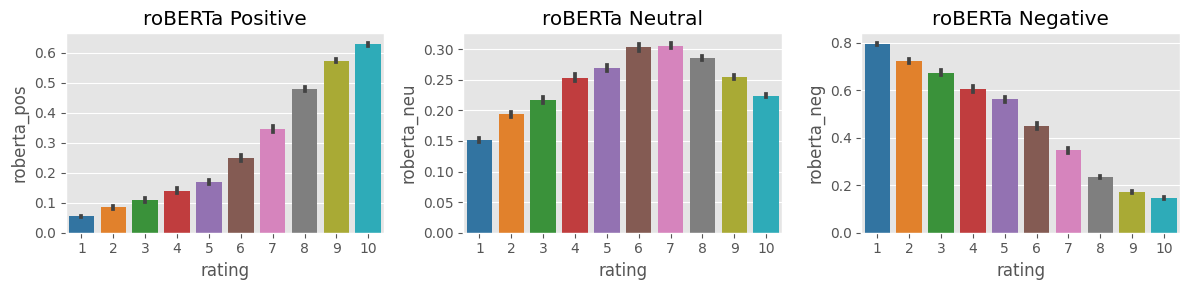

In [147]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=roberta_df, x="rating", y="roberta_pos", ax=axs[0],palette="tab10")
sns.barplot(data=roberta_df, x="rating", y="roberta_neu", ax=axs[1],palette="tab10")
sns.barplot(data=roberta_df, x="rating", y="roberta_neg", ax=axs[2],palette="tab10")
axs[0].set_title("roBERTa Positive")
axs[1].set_title("roBERTa Neutral")
axs[2].set_title("roBERTa Negative")
plt.tight_layout()
plt.show()

In [142]:
roberta_neg_reviews_df = roberta_df[roberta_df["roberta_neg"]>roberta_df["roberta_pos"]].groupby("condition").agg({"condition":"count"})
roberta_neg_reviews_df = roberta_neg_reviews_df.rename(columns={"condition":"neg_count"})
roberta_neg_reviews_df.reset_index(inplace=True)
roberta_neg_reviews_df = roberta_neg_reviews_df.merge(condition_tcount_df,how="left")
roberta_neg_reviews_df["neg_ratio"] = (np.array(roberta_neg_reviews_df["neg_count"])/np.array(roberta_neg_reviews_df["total_count"]))*100
roberta_neg_reviews_df["pos_ratio"] = 100-roberta_neg_reviews_df["neg_ratio"]
roberta_neg_reviews_df

,condition,neg_count,total_count,neg_ratio,pos_ratio
0,Acne,2181,5588,39.030064,60.969936
1,Anxiety,2294,5904,38.855014,61.144986
2,Birth Control,15977,28788,55.498819,44.501181
3,Depression,3812,9069,42.033300,57.966700
4,Pain,2589,6145,42.131814,57.868186


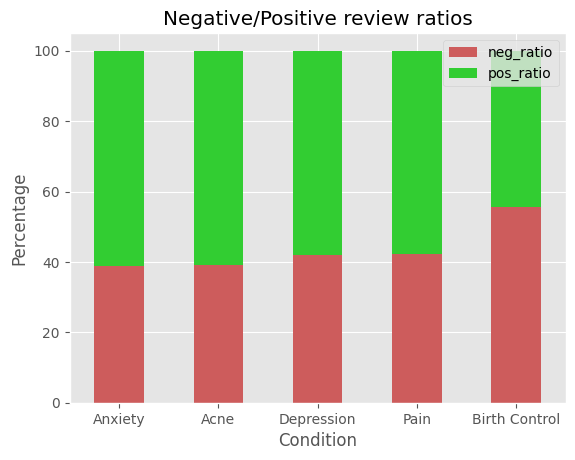

In [143]:
roberta_neg_reviews_df.sort_values("neg_ratio").drop(columns=["neg_count","total_count"]).plot(x="condition",kind='bar', stacked=True, color=['indianred', 'limegreen'])
plt.xticks(rotation=0)
plt.xlabel("Condition")
plt.ylabel("Percentage")
plt.title("Negative/Positive review ratios")
plt.show()

### Word cloud (What elements of a review make it more helpful to others? )

In [205]:
df_train["condition"].unique()

array(['Birth Control', 'Depression', 'Pain', 'Anxiety', 'Acne'],
      dtype=object)

In [279]:
df_train.sort_values("usefulCount",ascending=False).head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
11403,119152,Zoloft,Depression,"""I remember reading people&#039;s opinions, on...",10,31-Jul-08,1291
2330,96616,Sertraline,Depression,"""I remember reading people&#039;s opinions, on...",10,31-Jul-08,1291
1523,182560,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247
7483,131116,Levonorgestrel,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247
50309,119151,Zoloft,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...",9,5-Aug-08,949


In [206]:
df_BirCon = df_train[df_train["condition"]=="Birth Control"]
df_Dep = df_train[df_train["condition"]=="Depression"]
df_Pain = df_train[df_train["condition"]=="Pain"]
df_Anxiety = df_train[df_train["condition"]=="Anxiety"]
df_Acne = df_train[df_train["condition"]=="Acne"]

In [209]:
df_BirCon.sort_values("usefulCount",ascending=False).head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
1523,182560,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247
7483,131116,Levonorgestrel,Birth Control,"""I have had my IUD for over a year now and I t...",10,1-Apr-09,1247
1864,107655,Implanon,Birth Control,"""I was very nervous about trying Implanon afte...",10,19-Jul-10,730
9834,131155,Levonorgestrel,Birth Control,"""I love my Mirena. I&#039;ve recommended it to...",10,1-Oct-08,505
22916,182492,Mirena,Birth Control,"""I love my Mirena. I&#039;ve recommended it to...",10,1-Oct-08,505


In [231]:
df_BirCon[df_BirCon["rating"]==1].sort_values("usefulCount",ascending=False).head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
49013,182379,Mirena,Birth Control,"""I have had this for about 5 months now.. I ha...",1,7-May-10,470
50795,228266,Etonogestrel,Birth Control,"""December 1 2008, I had the Implanon inserted ...",1,27-Apr-09,200
25778,133497,Tri-Sprintec,Birth Control,"""Within the 1st week I went from a happy optim...",1,17-Dec-09,138
11246,44515,Ethinyl estradiol / norgestimate,Birth Control,"""Within the 1st week I went from a happy optim...",1,17-Dec-09,138
31622,228223,Etonogestrel,Birth Control,"""I had Implanon inserted in December 08. I hav...",1,22-Jul-09,136


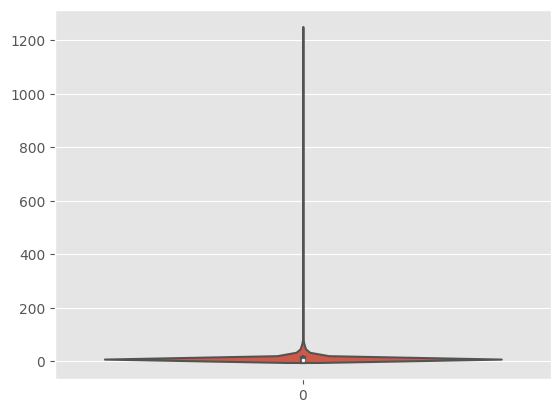

In [210]:
sns.violinplot(df_BirCon["usefulCount"])
plt.show()

In [211]:
df_BirCon["usefulCount"].describe()

count    28788.000000
mean         7.792344
std         17.673734
min          0.000000
25%          2.000000
50%          5.000000
75%          9.000000
max       1247.000000
Name: usefulCount, dtype: float64

In [212]:
df_BirCon.sort_values("usefulCount",ascending=False)["review"].values[0]

'"I have had my IUD for over a year now and I think it&#039;s the best thing ever. When I first got it put in I only bled for about a week with a little cramping. After that nothing at all. I haven&#039;t had a period for about 8months until I finally got one, and its not bad at all. It&#039;s light, no cramping, no headache, nothing. I haven&#039;t gained weight, my acne is gone, and my moods are fine. I know all women are different, but I just hear all these horror stories and I just wanted to tell my story, which is a good one. Hope it calms some of your fears."'

In [275]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

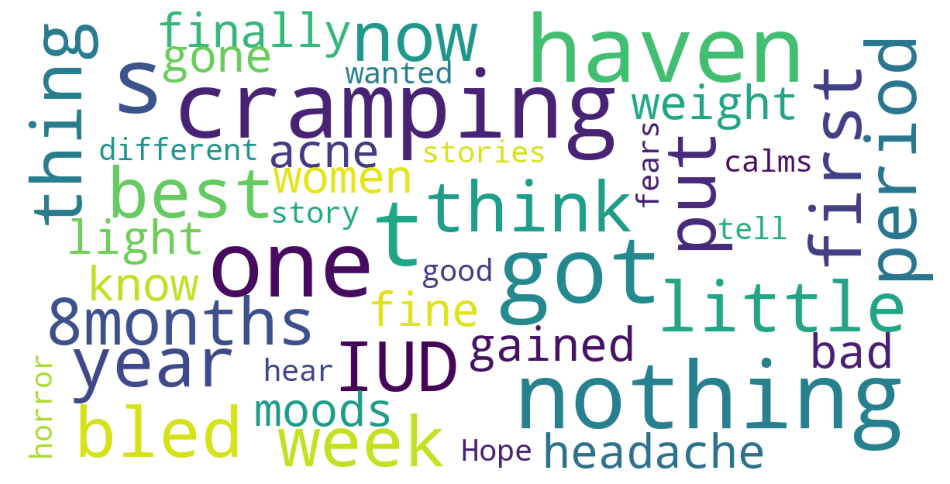

In [276]:
show_wordcloud(df_BirCon.sort_values("usefulCount",ascending=False)["review"].values[0]) # top usefulCount review

In [214]:
df_BirCon[["usefulCount"]].quantile(q=0.9)

usefulCount    16.0
Name: 0.9, dtype: float64

In [277]:
def get_all_text(df):
    text = ""
    for i,row in df[["review"]].iterrows():
        text+=row["review"]
    return text

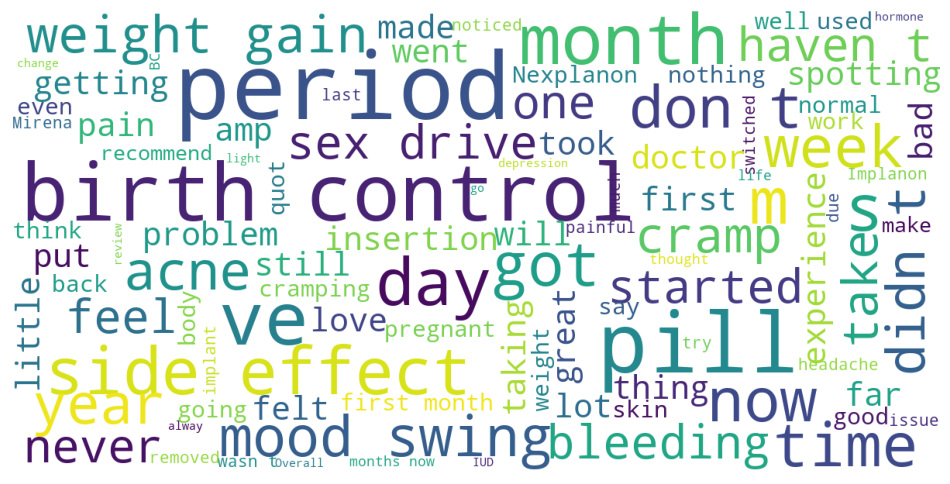

In [278]:
doc = df_BirCon
show_wordcloud(get_all_text(doc)) # all of birthcontrol

      uniqueID drugName      condition  \
188     149097   Mirena  Birth Control   
954     148371   Mirena  Birth Control   
1228    149453   Mirena  Birth Control   
2486    149690   Mirena  Birth Control   
2772    148767   Mirena  Birth Control   

                                                 review  rating       date  \
188   "I am 22, no prior children, I have endometrio...       1   8-Aug-15   
954   "I had hair loss and lack of appetite when I h...       1   6-Sep-17   
1228  "This is Jean&#039;s husband. Jean had this de...       1  31-Oct-13   
2486  "My problems with it: Bled for 4 or 5 months s...       1  27-Mar-12   
2772  "I wouldn&#039;t recommend it to my worst enem...       1  31-May-16   

      usefulCount  
188            20  
954             0  
1228           63  
2486            8  
2772            7  


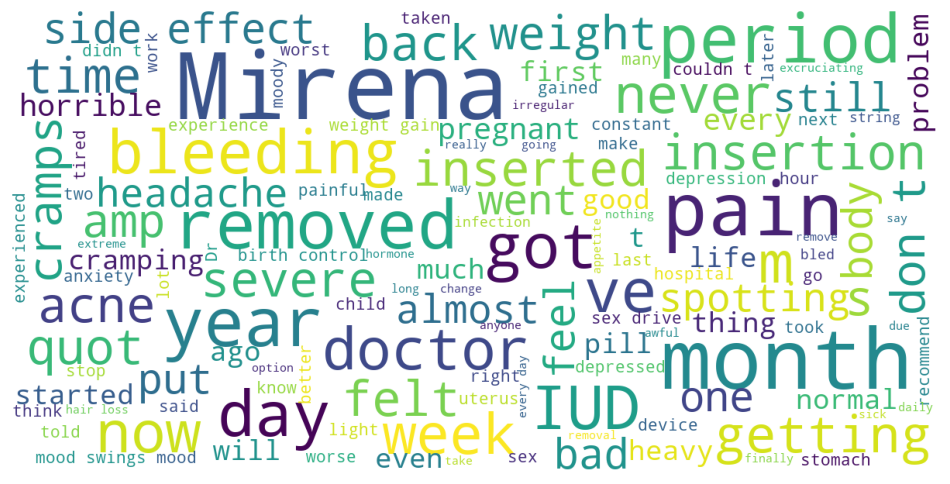

In [273]:
doc = df_BirCon[(df_BirCon["drugName"]=="Mirena") & (df_BirCon["rating"]==1)] # rating = 1
print(doc.head())
show_wordcloud(get_all_text(doc))

      uniqueID drugName      condition  \
68      149508   Mirena  Birth Control   
258     148832   Mirena  Birth Control   
436     149640   Mirena  Birth Control   
733     149800   Mirena  Birth Control   
1456    148422   Mirena  Birth Control   

                                                 review  rating       date  \
68    "I love my Mirena. I&#039;m due in February to...      10  14-Jan-13   
258   "I have had a wonderful experience with mirena...      10  16-Mar-16   
436   "I&#039;ve had the Mirena for more than a year...      10  21-Jun-12   
733   "Mirena has been greaat for me. We have one ch...      10   5-Sep-11   
1456  "I am 18 and have never gave birth and was pre...      10  18-Aug-17   

      usefulCount  
68             16  
258             6  
436             0  
733             0  
1456            6  


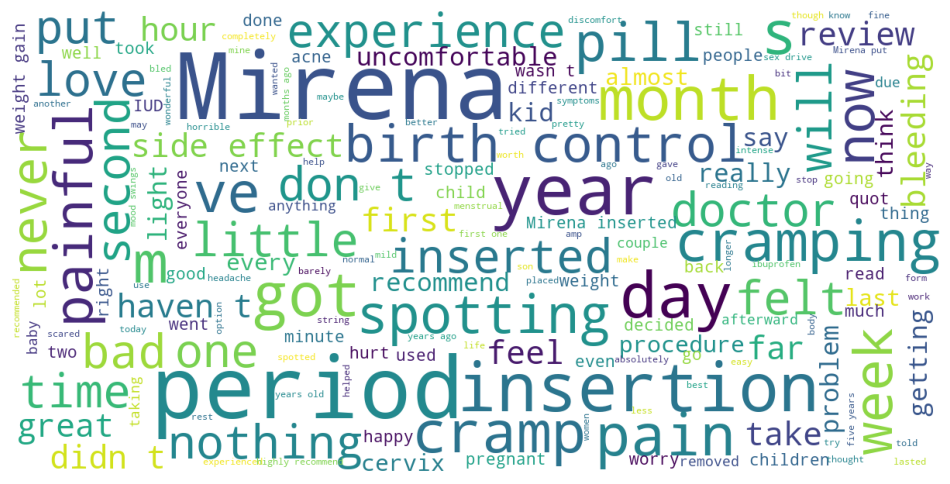

In [274]:
doc = df_BirCon[(df_BirCon["drugName"]=="Mirena") & (df_BirCon["rating"]==10)] # rating = 10
print(doc.head())
show_wordcloud(get_all_text(doc))

In [287]:
df_Acne.describe()

,uniqueID,rating,usefulCount
count,5588.000000,5588.000000,5588.000000
mean,114997.803865,7.374195,15.848604
std,63479.786806,3.042817,17.822163
min,868.000000,1.000000,0.000000
25%,53499.750000,6.000000,5.000000
50%,136884.000000,9.000000,11.000000
75%,159142.000000,10.000000,20.250000
max,230746.000000,10.000000,173.000000


     uniqueID                          drugName condition  \
48      63687                            Epiduo      Acne   
291    157819                          Accutane      Acne   
359    135157                           Dapsone      Acne   
503     85717  Ethinyl estradiol / norgestimate      Acne   
753    180778                           Solodyn      Acne   

                                                review  rating       date  \
48   "Update:\r\r\nMy skin initially cleared up for...      10   3-Dec-13   
291  "Unreal difference.  My side effects are minim...      10  24-Dec-14   
359  "I have tried almost everything under the sun ...      10   2-Apr-10   
503  "I&#039;ve been on this birth control for six ...      10  21-Mar-14   
753  "My 12 year old daughter has suffered from acn...      10   3-Sep-12   

     usefulCount  
48            34  
291           78  
359           39  
503           38  
753           26  


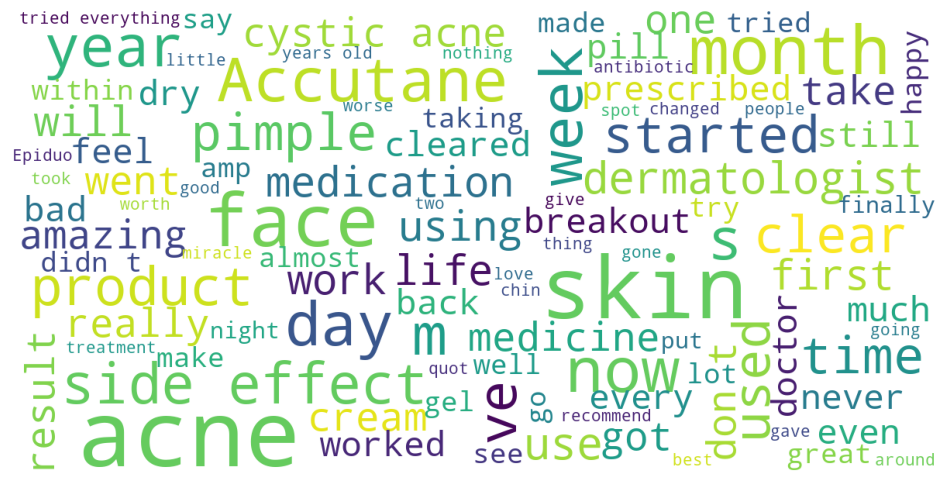

In [291]:
doc = df_Acne[(df_Acne["rating"]==10) & (df_Acne["usefulCount"]>20)] # rating = 10
print(doc.head())
show_wordcloud(get_all_text(doc))

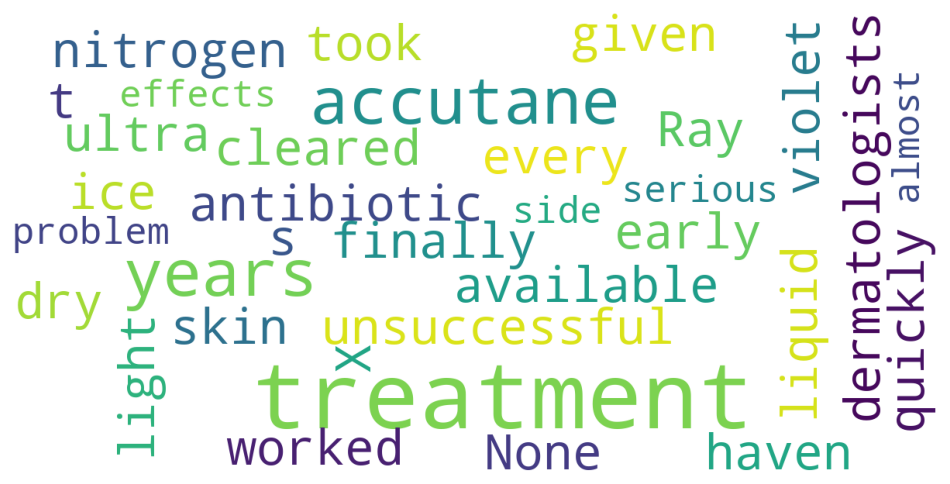

In [299]:
show_wordcloud(df_Acne.sort_values("usefulCount",ascending=False)["review"].values[0]) # rating = 10 top review

      uniqueID     drugName condition  \
2572     46753  Clindamycin      Acne   
2766     47782    Adapalene      Acne   
4239     34823  Minocycline      Acne   
6487     47754    Adapalene      Acne   
7453    101502      Atralin      Acne   

                                                 review  rating       date  \
2572  "Do not take this!! Worst experience of my lif...       1  29-Mar-16   
2766  "(A little background on my skin, I get a pimp...       1  15-Feb-17   
4239  "I was on minocycline for about 3 years for ac...       1  31-Dec-13   
6487  "I was prescribed Differin 3 weeks ago. Two da...       1   4-Dec-16   
7453  "I used this medicine for about two months. I ...       1   1-Feb-10   

      usefulCount  
2572           28  
2766           22  
4239           27  
6487           33  
7453           28  


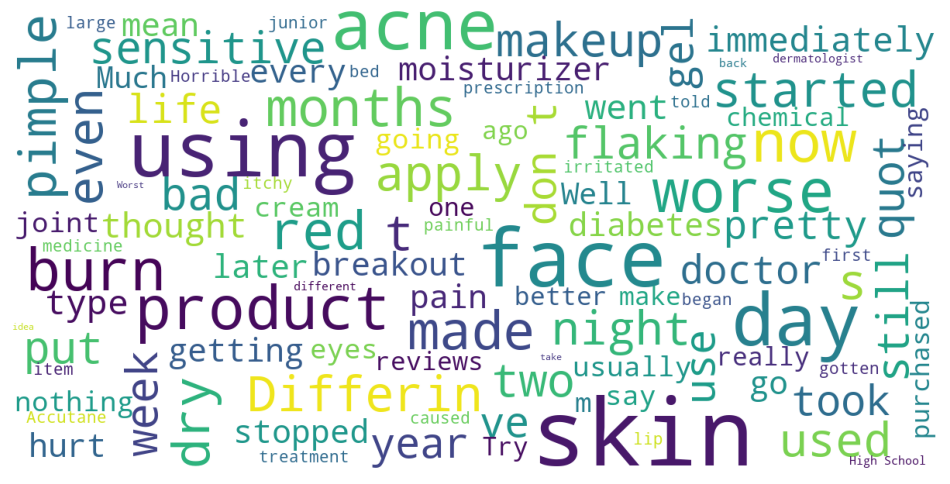

In [290]:
doc = df_Acne[(df_Acne["rating"]==1) & (df_Acne["usefulCount"]>20)] # rating = 1
print(doc.head())
show_wordcloud(get_all_text(doc))

In [292]:
df_Pain.describe()

,uniqueID,rating,usefulCount
count,6145.000000,6145.000000,6145.000000
mean,101148.205696,7.632221,35.574451
std,64265.560983,2.928199,41.951497
min,1469.000000,1.000000,0.000000
25%,47435.000000,7.000000,12.000000
50%,90213.000000,9.000000,23.000000
75%,152625.000000,10.000000,44.000000
max,231175.000000,10.000000,485.000000


     uniqueID       drugName condition  \
14      69488  Buprenorphine      Pain   
103    103246      Celecoxib      Pain   
223    189497      Oxycodone      Pain   
229     69392  Buprenorphine      Pain   
280     23322      Methadone      Pain   

                                                review  rating       date  \
14   "I love my Butrans patch!!! And it has relieve...      10   6-Aug-15   
103  "I LOVE Celebrex!  I have degenerative disk di...      10  17-Feb-10   
223  "Life is livable again. I have had no side eff...      10   2-Nov-11   
229  "So I have been on the BuTrans patch 10microgr...      10   9-Sep-16   
280  "I started methadone a few days ago and oh my ...      10  17-Mar-12   

     usefulCount  
14            47  
103          105  
223           74  
229           54  
280           91  


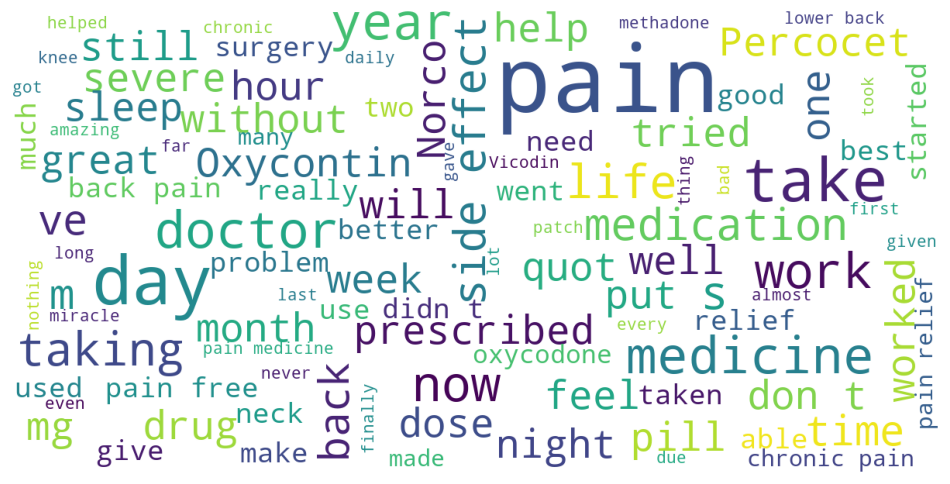

In [295]:
doc = df_Pain[(df_Pain["rating"]==10) & (df_Pain["usefulCount"]>44)] # rating = 10
print(doc.head())
show_wordcloud(get_all_text(doc))

# Model comparisons
1. Evaluation metrics

In [54]:
results

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors,CharLevel Vectors
BernoulliNB,0.882061,0.871700,0.796018,0.785566
Logistic Regression,0.939814,0.927561,0.885215,0.921164
SVC,0.916389,0.950536,0.920623,0.942607
RandomForestClassifier,0.933508,0.939094,0.905937,0.933958


In [76]:
results_reg

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors,CharLevel Vectors
LinearRegression,0.238124,0.221283,0.148395,0.186759


In [321]:
(0.933508	+0.939094+0.905937	+0.933958)/4

0.9281242500000001